# Equivalent width fitting
This notebook is an example of how to go from measured equivalent widths to abundances.  We'll use the data from [Melendez 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...791...14M/abstract) and redo their differential analysis of iron lines 18 Sco.

In [1]:
using Revise, Korg, DataFrames, CSV, PyPlot

[ Info: Precompiling Korg [acafc109-a718-429c-b0e5-afd7f8c7ae46]


## parsing the linelist

In [2]:
# use the CSV library to read the contents of Table 1, which were downloaded from the journal website
# the "lines" objects is a DataFrame, which we'll use to organize our data
lines = CSV.read("Table 1.dat", DataFrame; skipto=25, delim=' ', ignorerepeated=true,
    header=["wl", "species", "ExPot", "log_gf", "C6", "EW_18Sco", "EW_Sun"])

# convert the numbers in the species column to Korg.Species objects
lines.species = Korg.Species.(lines.species)

# let's look at Fe lines only
filter!(lines) do row
    Korg.get_atoms(row.species) == [26]
end

#sort by wavelength
sort!(lines, :wl)
;

In [3]:
# to pass the lines to Korg, we need to turn each row of the "lines" DataFrame into a Korg.Line object
linelist = Korg.Line.(lines.wl, # can be in either cm or Å (like these), but NOT nm
                      lines.log_gf,
                      lines.species, # needs to be a Korg.Species, which we handled in the cell above
                      lines.ExPot) # excitation potential, i.e. lower level energy (must be in eV)
;

## Set up params for each star

In [4]:
# solar params
sun_Teff, sun_logg, sun_Fe_H, sun_vmic = 5777, 4.44, 0.0, 1.0

# vector of abundances for the sun
sun_A_X = Korg.format_A_X(sun_Fe_H)

# interpolate a model atmosphere for the sun
sun_atm = Korg.interpolate_marcs(sun_Teff, sun_logg, sun_A_X)  

# and likewise for 18 Sco
sco_teff, sco_logg, sco_fe_h, sco_vmic = (5823, 4.45, 0.054, sun_vmic + 0.02)
sco_A_X = Korg.format_A_X(sco_fe_h)
sco_atm = Korg.interpolate_marcs(sco_teff, sco_logg, sco_A_X)

[ Info: loading the model atmosphere grid into memory. This will take a few seconds, but will only happen once per julia session.


Korg.PlanarAtmosphere{Float64, Float64, Float64, Float64, Float64} with 56 layers

## Calculate the abundances for each star
Because Julia uses "just in time" compilation, the first call to `Korg.Fit.ews_to_abundances` will take several seconds.  The second is much faster, because the code is already compiled.  If you rerun the cell below, both calculations will be fast, even though no data is cached.

In [5]:
# calculate abundances from the EWs for each star
@time lines.A_sun = Korg.Fit.ews_to_abundances(sun_atm, linelist, sun_A_X, lines.EW_Sun, vmic=sun_vmic)
@time lines.A_18Sco = Korg.Fit.ews_to_abundances(sco_atm, linelist, sco_A_X, lines.EW_18Sco, vmic=sco_vmic)
;

 18.033960 seconds (103.51 M allocations: 7.324 GiB, 5.10% gc time, 84.61% compilation time)
  2.616027 seconds (15.51 M allocations: 2.969 GiB, 8.50% gc time)


# Plot the results
Plotting as a function of wavelength and equivalenth width is left as an excercise for the reader.

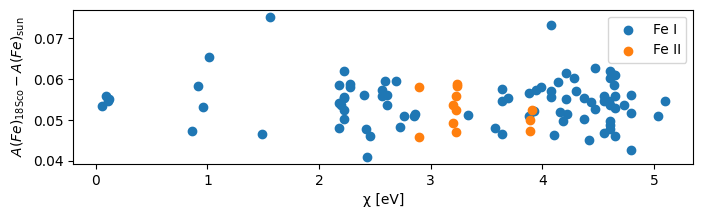

In [6]:
# get a bitmask for the lines of Fe I vs Fe II
neutrals = [spec.charge == 0 for spec in lines.species]

figure(figsize=(8, 2))
scatter(lines.ExPot[neutrals], (lines.A_18Sco - lines.A_sun)[neutrals], label="Fe I")
scatter(lines.ExPot[.! neutrals], (lines.A_18Sco - lines.A_sun)[.! neutrals], label="Fe II")
ylabel(L"A(Fe)_\mathrm{18 Sco} - A(Fe)_\mathrm{sun}")
xlabel("χ [eV]")
legend()
;